Online travel agencies are scrambling to meet the artificial intelligence driven personalization standard set by companies 
like Amazon and Netflix. In addition, the world of online travel has become a highly competitive space where brands try 
to capture our attention (and wallet) with recommending, comparing, matching, and sharing. 
For this assignment, we would like to create the optimal hotel recommendations for Expedia’s users that are searching for a 
hotel to book. For this assignment, you need to predict which “hotel cluster” the user is likely to book, 
given his (or her) search details.

Approach - the problem is identifying the hotel clusters and predicting which cluster a customer is likely to pick based off of 
previous selections based on country of origin and popular hotel picks 

In [24]:
##View os and imports
import pandas as pd
import pandas_profiling as pp
import seaborn as sns
import numpy as np
import warnings
import matplotlib.pyplot as plt

##Imports that were used through some research 
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from datetime import datetime
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing

##Graph configuration
%matplotlib inline

##ignore warnings from out of date imports or soon to be
warnings.simplefilter('ignore')
print (os)

<module 'os' from 'C:\\Users\\14029\\anaconda3\\lib\\os.py'>


In [58]:
##load training data

train = pd.read_csv('train.csv', nrows = 100000)

##load test data
test = pd.read_csv('test.csv', nrows=100000)

##load destination data
destination = pd.read_csv('destinations.csv', nrows=100000)

In [40]:
train.head()

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
0,2014-08-11 07:46:59,2,3,66,348,48862,2234.2641,12,0,1,...,0,1,8250,1,0,3,2,50,628,1
1,2014-08-11 08:22:12,2,3,66,348,48862,2234.2641,12,0,1,...,0,1,8250,1,1,1,2,50,628,1
2,2014-08-11 08:24:33,2,3,66,348,48862,2234.2641,12,0,0,...,0,1,8250,1,0,1,2,50,628,1
3,2014-08-09 18:05:16,2,3,66,442,35390,913.1932,93,0,0,...,0,1,14984,1,0,1,2,50,1457,80
4,2014-08-09 18:08:18,2,3,66,442,35390,913.6259,93,0,0,...,0,1,14984,1,0,1,2,50,1457,21


In [41]:
train.columns

Index(['date_time', 'site_name', 'posa_continent', 'user_location_country',
       'user_location_region', 'user_location_city',
       'orig_destination_distance', 'user_id', 'is_mobile', 'is_package',
       'channel', 'srch_ci', 'srch_co', 'srch_adults_cnt', 'srch_children_cnt',
       'srch_rm_cnt', 'srch_destination_id', 'srch_destination_type_id',
       'is_booking', 'cnt', 'hotel_continent', 'hotel_country', 'hotel_market',
       'hotel_cluster'],
      dtype='object')

<AxesSubplot:xlabel='channel', ylabel='count'>

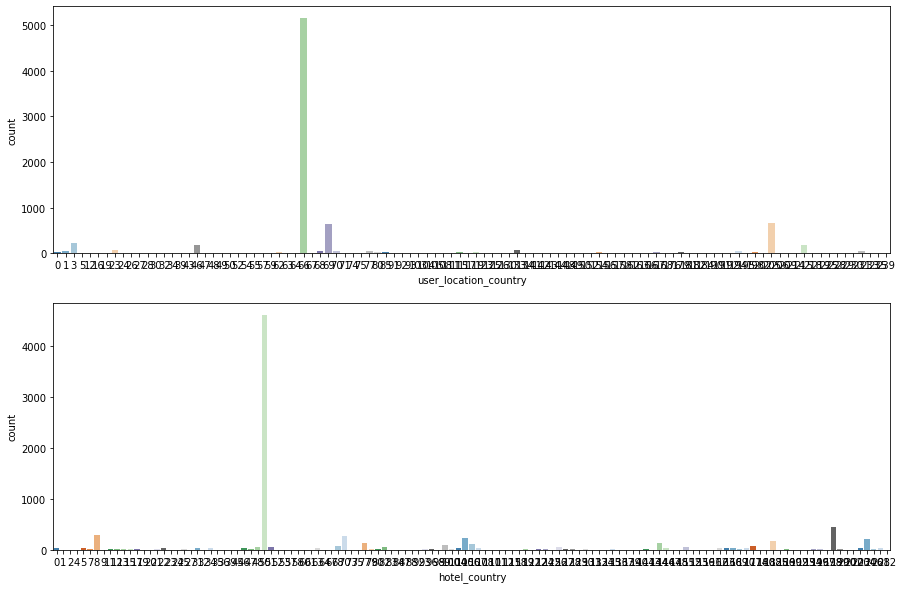

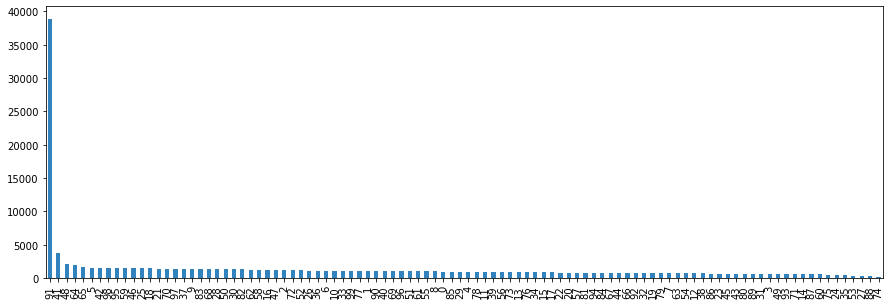

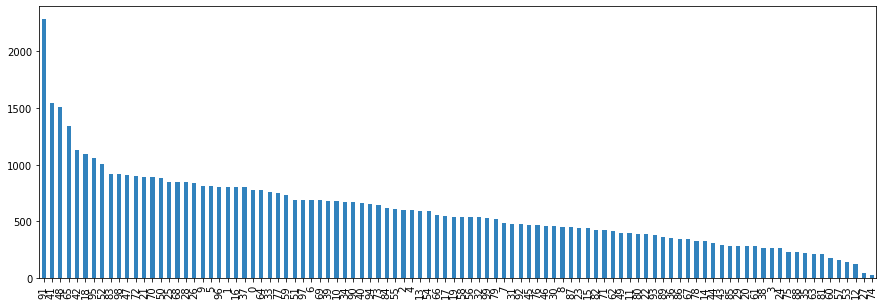

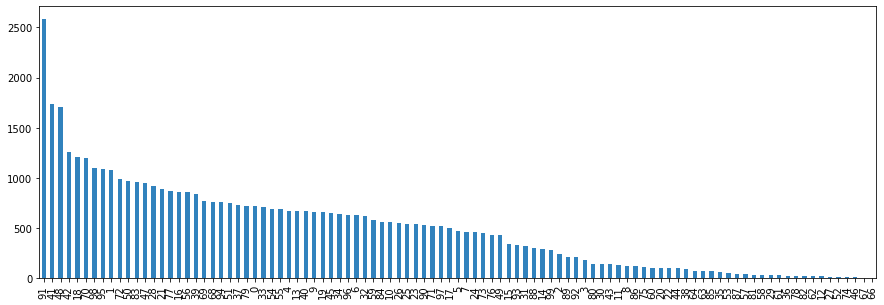

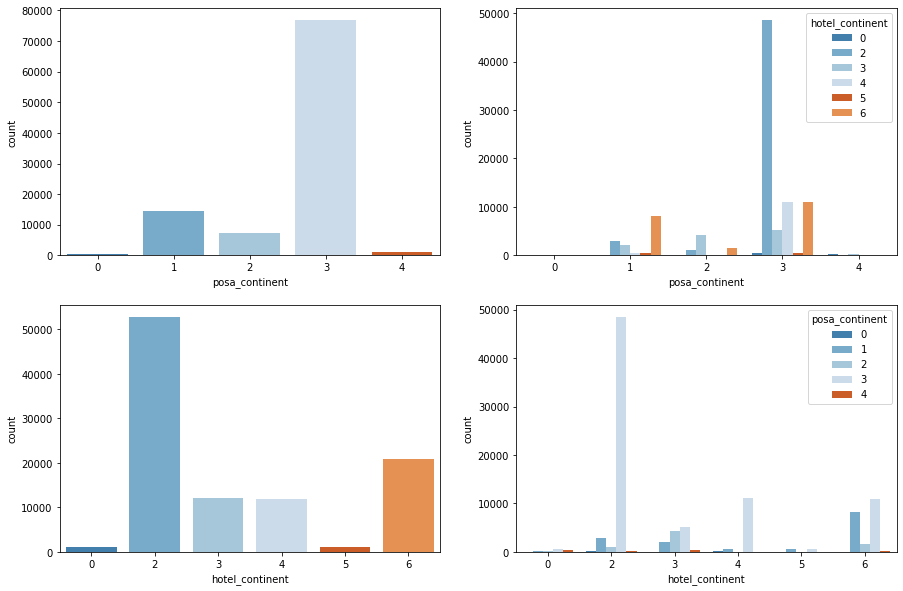

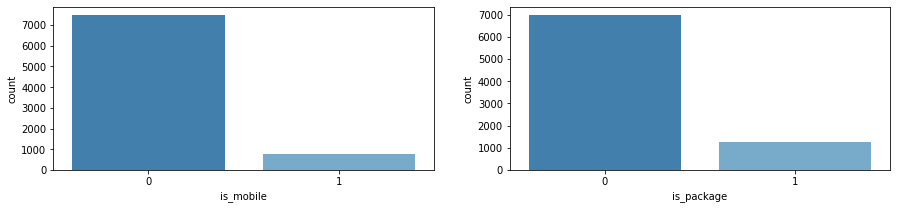

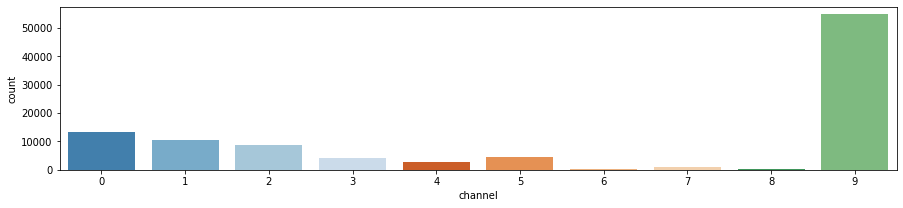

In [47]:
##cleaning the data to remove useres who did not book a hotel
##identify 'searches by destination'
##clear Nan values
##view duration of days stayed for each entry

##Plot to view if cust booked or just viewed
bookings_df = train[train["is_booking"] == 1]
fig, (axis1,axis2) = plt.subplots(2,1,figsize=(15,10))
##Country of origin
sns.countplot('user_location_country',data=bookings_df.sort_values(by=['user_location_country']),ax=axis1,palette='tab20c')

##view country data
sns.countplot('hotel_country',data=bookings_df.sort_values(by=['hotel_country']),ax=axis2,palette='tab20c')

##Combine both plots

##Country of origing combined plot
user_country_id = 66
fig, (axis1) = plt.subplots(1,1,figsize=(15,10))
country_customers = train[train["user_location_country"] == user_country_id]
country_customers["hotel_country"].value_counts().plot(kind='bar',colormap='tab20c',figsize=(15,5))

##Plot frequency for each hotel_clusters
train["hotel_cluster"].value_counts().plot(kind='bar',colormap='tab20c',figsize=(15,5))

##Hotels by country
fig, (axis1) = plt.subplots(1,1,figsize=(15,10))
customer_clusters = train[train["user_location_country"] == user_country_id]["hotel_cluster"]
customer_clusters.value_counts().plot(kind='bar',colormap='tab20c',figsize=(15,5))

country_id = 50
fig, (axis1) = plt.subplots(1,1,figsize=(15,10))
country_clusters = train[train["hotel_country"] == country_id]["hotel_cluster"]
country_clusters.value_counts().plot(kind='bar',colormap='tab20c',figsize=(15,5))

##Plot post_continent & hotel_continent
fig, ((axis1,axis2),(axis3,axis4)) = plt.subplots(2,2,figsize=(15,10))

##Plot each posa_continent
sns.countplot('posa_continent', data=train,order=[0,1,2,3,4],palette='tab20c',ax=axis1)

##Plot each posa_continent by hotel_continent
sns.countplot('posa_continent', hue='hotel_continent',data=train,order=[0,1,2,3,4],palette='tab20c',ax=axis2)

##Plot each hotel_continent
sns.countplot('hotel_continent', data=train,order=[0,2,3,4,5,6],palette='tab20c',ax=axis3)

##Plot each hotel_continent by posa_continent
sns.countplot('hotel_continent', hue='posa_continent', data=train, order=[0,2,3,4,5,6],palette='tab20c',ax=axis4)

##Plot frequency of is_mobile & is_package
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,3))

##Mobile bookin
sns.countplot(x='is_mobile',data=bookings_df, order=[0,1], palette='tab20c', ax=axis1)

##Booking with packages
sns.countplot(x='is_package',data=bookings_df, order=[0,1], palette='tab20c', ax=axis2)

# What's the most impactful channel?
fig, (axis1) = plt.subplots(1,1,figsize=(15,3))
sns.countplot(x='channel', order=list(range(0,10)), data=train, palette='tab20c')

<AxesSubplot:>

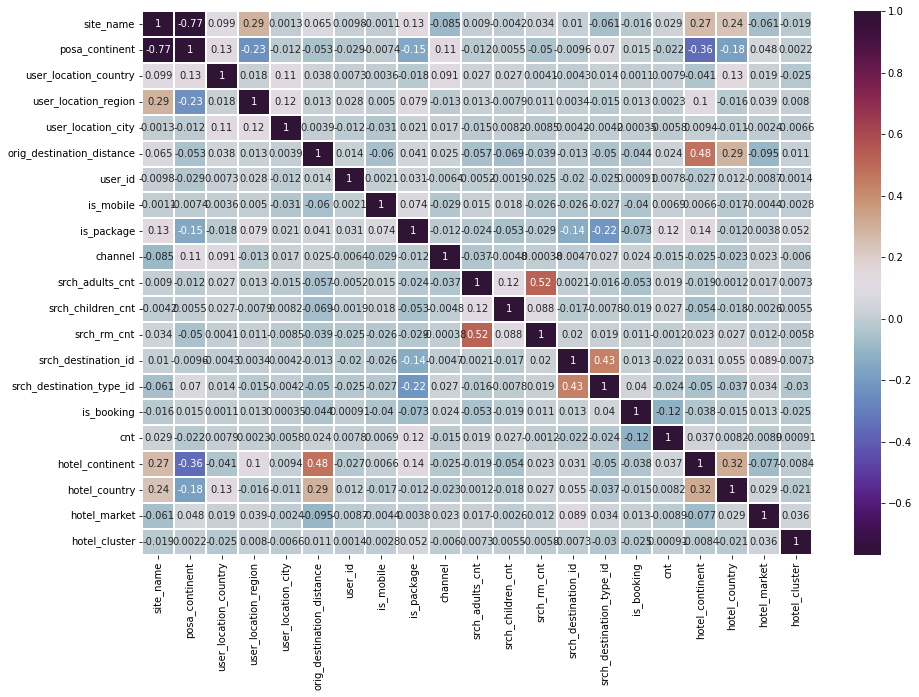

In [50]:
##heatmap set up 
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
sns.heatmap(train.corr(),cmap='twilight_shifted',ax=ax,annot=True,linewidths=2)

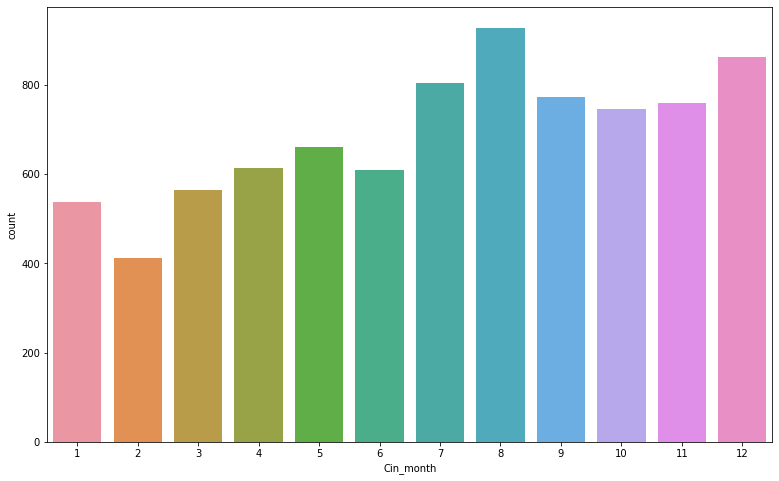

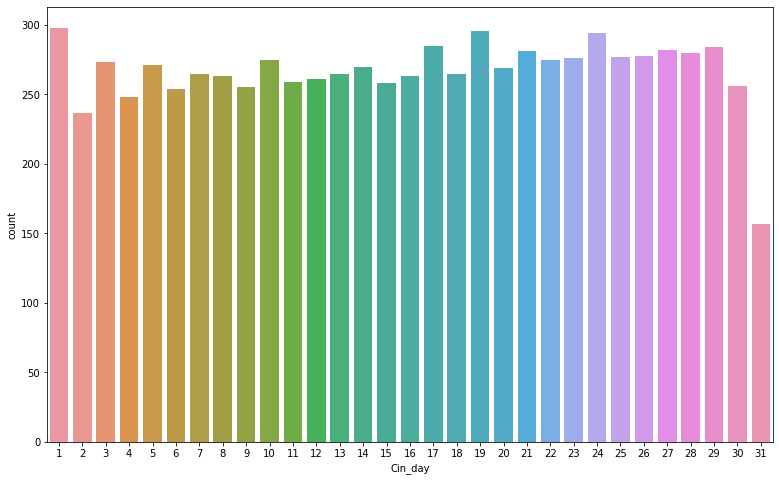

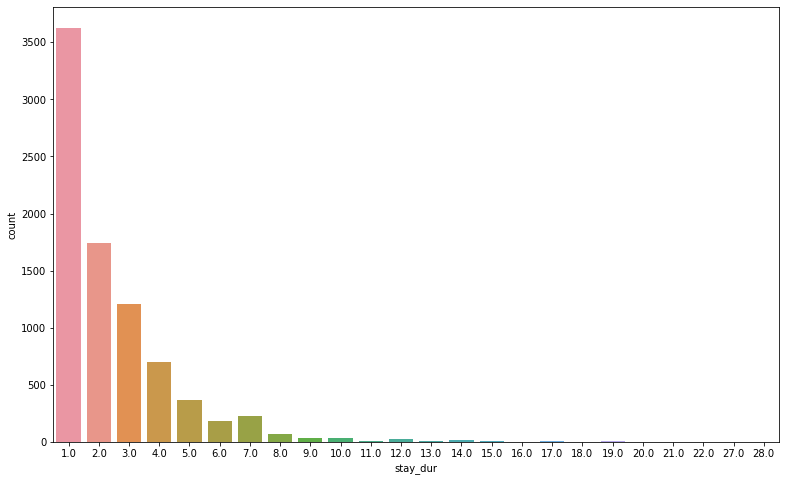

In [54]:
##Feature engineering
##Converting date attributes
def convert_date_into_days(df):
    df['srch_ci'] = pd.to_datetime(df['srch_ci'])
    df['srch_co'] = pd.to_datetime(df['srch_co'])
    df['date_time'] = pd.to_datetime(df['date_time'])
    
    df['stay_dur'] = (df['srch_co'] - df['srch_ci']).astype('timedelta64[D]')
    df['no_of_days_bet_booking'] = (df['srch_ci'] - df['date_time']).astype('timedelta64[D]')
    
    ##Hotel Check in by year, month and day
    df['Cin_day'] = df["srch_ci"].apply(lambda x: x.day)
    df['Cin_month'] = df["srch_ci"].apply(lambda x: x.month)
    df['Cin_year'] = df["srch_ci"].apply(lambda x: x.year)
    
convert_date_into_days(train)
convert_date_into_days(test)

# Count the bookings in each month
fig, ax = plt.subplots()
fig.set_size_inches(13, 8)
sns.countplot('Cin_month',data=train[train["is_booking"] == 1],order=list(range(1,13)),ax=ax)

# Count the bookings as per the day
fig, ax = plt.subplots()
fig.set_size_inches(13, 8)
sns.countplot('Cin_day',data=train[train["is_booking"] == 1],order=list(range(1,32)),ax=ax)

# Count the bookings as per the stay_duration
fig, ax = plt.subplots()
fig.set_size_inches(13, 8)
sns.countplot('stay_dur',data=train[train["is_booking"] == 1],ax=ax)

# drop unnecessary columns, these columns won't be useful in analysis and prediction
test_user_id = test['user_id']
columns = ['date_time', 'srch_ci','user_id','srch_destination_type_id','srch_destination_id', 'site_name', 'user_location_region', 'user_location_city', 
                              'user_id', 'srch_co', 'srch_adults_cnt', 'srch_children_cnt', 'srch_rm_cnt']
train.drop(columns=columns,axis=1,inplace=True)
test.drop(columns=columns,axis=1,inplace=True)

In [57]:
##1 - train data using specific columns
train = pd.read_csv('train.csv',
                    dtype={'is_booking':bool,'srch_destination_id':np.int32, 'hotel_cluster':np.int32},
                    usecols=['srch_destination_id','is_booking','hotel_cluster'],
                    chunksize=1000000)
aggs = []
print('-'*38)
for chunk in train:
    agg = chunk.groupby(['srch_destination_id',
                         'hotel_cluster'])['is_booking'].agg(['sum','count'])
    agg.reset_index(inplace=True)
    aggs.append(agg)
    print('.',end='')
print('')
aggs = pd.concat(aggs, axis=0)
aggs.head()

##2 - compute total bookings by cluster

CLICK_WEIGHT = 0.05
agg = aggs.groupby(['srch_destination_id','hotel_cluster']).sum().reset_index()
agg['count'] -= agg['sum']
agg = agg.rename(columns={'sum':'bookings','count':'clicks'})
agg['relevance'] = agg['bookings'] + CLICK_WEIGHT * agg['clicks']
agg.head()

##Define function for most popular hotels 
def most_popular(group, n_max=5):
    relevance = group['relevance'].values
    hotel_cluster = group['hotel_cluster'].values
    most_popular = hotel_cluster[np.argsort(relevance)[::-1]][:n_max]
    return np.array_str(most_popular)[1:-1] ##remove excess

##Popular hotels by destination
most_pop = agg.groupby(['srch_destination_id']).apply(most_popular)
most_pop = pd.DataFrame(most_pop).rename(columns={0:'hotel_cluster'})
most_pop.head()

##3 - Read in data vs clusters
test = pd.read_csv('test.csv',
                    dtype={'srch_destination_id':np.int32},
                    usecols=['srch_destination_id'],)
test = test.merge(most_pop, how='left',left_on='srch_destination_id',right_index=True)
test.head()

##Remove excess
test.hotel_cluster.isnull().sum()

##Fill data 
most_pop_all = agg.groupby('hotel_cluster')['relevance'].sum().nlargest(5).index
most_pop_all = np.array_str(most_pop_all)[1:-1]
print(most_pop_all)

test.hotel_cluster.fillna(most_pop_all,inplace=True)

test.hotel_cluster.to_csv('submission.csv',header=True, index_label='id')

--------------------------------------
......................................
91 48 42 59 28


Step 1 was created to limit the amount of rows that were actually read to help predict the most popular hotels. Here I used is_booking, srch_destination_id and hotel_cluster to filter out who is actually booking versus who is just searching. It was compressed by location and then hotel cluster to assint in the output of 'submission.csv'

Step 2 was created to cross reference between the number of clicks on the user and the number of bookings for a weighted total of bookings to clicks. 

Step 3 is the final step to read in the data and compare from the test and the train csv files. Overall I was extremely happy with the output and the final most popular hotel clusters. 

If I had more time I would have liked to compare the results against a random forest but I am pleased with these results and had a lot of fun going through this project. 
